![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/jupyter/Cards/SparkOCRPdfToTable.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

In [2]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Saving spark-license-v430.json to spark-license-v430.json


In [3]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 KB 19.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.3.0-9c0f1a7c57f6ef6bb9153c66f61ae94ca5dcdd34
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.2/30.2 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: opencv-python
    Found existing installa

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [3]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 4.2.4
Spark OCR version: 4.3.0



## Load test images

In [ ]:
test_image_path = "data/pdfs/f1120.pdf"
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.select("path").show(truncate=False)

In [7]:
pdf_to_hocr = PdfToHocr() \
    .setOutputCol("hocr")

tokenizer = HocrTokenizer() \
        .setInputCol("hocr") \
        .setOutputCol("token") \

pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setPageNumCol("tmp_pagenum") \
        .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector \
        .pretrained("general_model_table_detection_v2", "en", "public/ocr/models") \
        .setInputCol("image") \
        .setOutputCol("table_regions") \
        .setScoreThreshold(0.9) \
        .setApplyCorrection(True) \
        .setScaleWidthToCol("width_dimension") \
        .setScaleHeightToCol("height_dimension")

image_scaler = ImageScaler() \
        .setWidthCol("width_dimension") \
        .setHeightCol("height_dimension")

hocr_to_table = HocrToTextTable() \
        .setInputCol("hocr") \
        .setRegionCol("table_regions") \
        .setOutputCol("tables")

draw_annotations = ImageDrawAnnotations() \
        .setInputCol("scaled_image") \
        .setInputChunksCol("tables") \
        .setOutputCol("image_with_annotations") \
        .setFilledRect(False) \
        .setFontSize(5) \
        .setRectColor(Color.red)

draw_regions = ImageDrawRegions() \
        .setInputCol("scaled_image") \
        .setInputRegionsCol("table_regions") \
        .setOutputCol("image_with_regions") \
        .setRectColor(Color.red)

pipeline1 = PipelineModel(stages=[
    pdf_to_hocr,
    tokenizer,
    pdf_to_image,
    table_detector,
    image_scaler,
    draw_regions,
    hocr_to_table,
    #draw_annotations,
])

result = pipeline1.transform(bin_df).cache().drop("tmp_pagenum")
result = result.filter(result.pagenum == 1)

display(result)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


path,modificationTime,length,hocr,height_dimension,width_dimension,pagenum,token,image,total_pages,documentnum,table_regions,scaled_image,image_with_regions,tables,exception,table_index
file:/content/f11...,2023-01-23 08:16:...,3471478,"<div title=""bbox ...",791,611,1,"[{token, 0, 2, 23...",{file:/content/f1...,1,0,"{0, 0, 32.839153,...",{file:/content/f1...,{file:/content/f1...,"{{0, 0, 0.0, 0.0,...",null,0



    Image #0:
    Origin: file:/content/f1120.pdf
    Resolution: 0 dpi
    Width: 611 px
    Height: 791 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


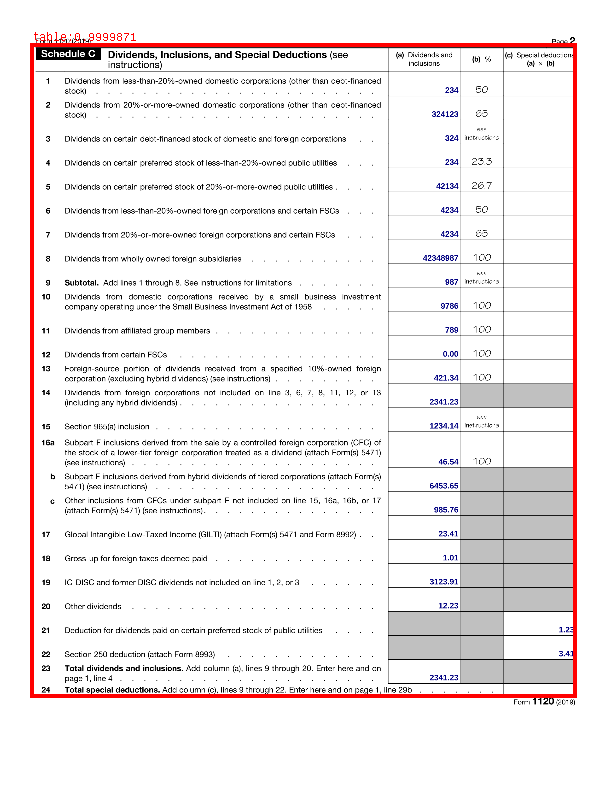

In [8]:
display_images(result, "image_with_regions", width=1000)

In [9]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: f1120.pdf
Page:     1
Table:    0
5


,col0,col1,col2,col3,col4
0,Schedule C,"Dividends instructions , ) Inclusions , and Sp...",( a ) Dividends inclusions and,( b ) %,( c ) Special ( a ) × deductions ( b )
1,1,Dividends from less - than - 20 % - owned dome...,234,50,None
2,2,Dividends from 20 % - or - more - owned domest...,324123,65,None
3,3,Dividends on certain debt - financed stock of ...,324,instructions see,None
4,4,Dividends on certain preferred stock of less -...,234,23 . 3,None
5,5,Dividends on certain preferred stock of 20 % -...,42134,26 . 7,None
6,6,Dividends from less - than - 20 % - owned fore...,4234,50,None
7,7,Dividends from 20 % - or - more - owned foreig...,4234,65,None
8,8,Dividends from wholly owned foreign subsidiaries,42348987,100,None
9,9,Subtotal . Add lines 1 through 8 . See instruc...,987,instructions see,None



    Image #0:
    Origin: file:/content/f1120.pdf
    Resolution: 0 dpi
    Width: 611 px
    Height: 791 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


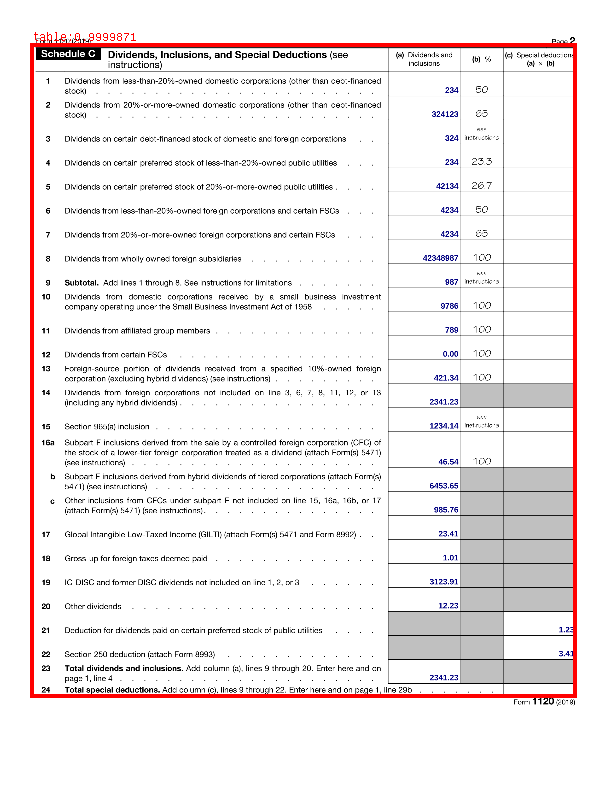

In [10]:
display_images(result, "image_with_regions", width=1000)